# Million Song Recommendation Engine

In this notebook the scope of coverage is limited to Popularity Based & Item Based Collaborative Filtering recommendation engine.We are going to use the Million Song dataset from the below source for our recommendation engine.

Dataset Source: http://labrosa.ee.columbia.edu/millionsong/

Paper: http://ismir2011.ismir.net/papers/OS6-1.pdf

Before we go into the details of implementation let us first understand some fundamental concepts .To start with there are fundamentally 3 types of recommendation engines namely

### Content-based filtering

*Recommend based on the user's rating history.* 

Generic expression (notice how this is kind of a 'row-based' approach):

$$ 
\newcommand{\aggr}{\mathop{\rm aggr}\nolimits}
r_{u,i} = \aggr_{i' \in I(u)} [r_{u,i'}]
$$


A simple example using the mean as an aggregation function:

$$ 
r_{u,i} = \bar r_u = \frac{\sum_{i' \in I(u)} r_{u,i'}}{|I(u)|} 
$$


### Collaborative filtering

*Recommend based on other user's rating histories.* 

Generic expression (notice how this is kind of a 'col-based' approach):

$$ 
\newcommand{\aggr}{\mathop{\rm aggr}\nolimits}
r_{u,i} = \aggr_{u' \in U(i)} [r_{u',i}] 
$$

A simple example using the mean as an aggregation function:

$$ 
r_{u,i} = \bar r_i = \frac{\sum_{u' \in U(i)} r_{u',i}}{|U(i)|} 
$$

### Hybrid solutions

The literature has lots of examples of systems that try to combine the strengths
of the two main approaches. This can be done in a number of ways:

- Combine the predictions of a content-based system and a collaborative system.
- Incorporate content-based techniques into a collaborative approach.
- Incorporarte collaborative techniques into a content-based approach.
- Unifying model.

### Challenges

#### Availability of item metadata

Content-based techniques are limited by the amount of metadata that is available
to describe an item. There are domains in which feature extraction methods are
expensive or time consuming, e.g., processing multimedia data such as graphics,
audio/video streams. In the context of grocery items for example, it's often the
case that item information is only partial or completely missing. Examples
include:

- Ingredients
- Nutrition facts
- Brand
- Description
- Country of origin

#### New user problem

A user has to have rated a sufficient number of items before a recommender
system can have a good idea of what their preferences are. In a content-based
system, the aggregation function needs ratings to aggregate.

#### New item problem

Collaborative filters rely on an item being rated by many users to compute
aggregates of those ratings. Think of this as the exact counterpart of the new
user problem for content-based systems.

#### Data sparsity

When looking at the more general versions of content-based and collaborative
systems, the success of the recommender system depends on the availability of a
critical mass of user/item iteractions. We get a first glance at the data
sparsity problem by quantifying the ratio of existing ratings vs $|U|x|I|$. A
highly sparse matrix of interactions makes it difficult to compute similarities
between users and items. As an example, for a user whose tastes are unusual
compared to the rest of the population, there will not be any other users who
are particularly similar, leading to poor recommendations.


Now that we had enough of theory lets jump in to implementing the recommendation engine.

Firstly let us import the required libraries to get started

In [4]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import Recommenders as Recommenders
import Evaluation as Evaluation

# Load Data

To load the complete we need to fetch from two sources
 
#### 1. Listen Count Triplets Data

In [5]:
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'

triplets_dataframe = pd.read_table(triplets_file,header=None)
triplets_dataframe.columns = ['user_id', 'song_id', 'listen_count']
triplets_dataframe.head()

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


#### 2. User & Song meta data

In [8]:
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

#Read song metadata
user_song_dataframe =  pd.read_csv(songs_metadata_file)
user_song_dataframe.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


Now that we observed the data structure of both the metadata(triplets) and song dataframe let us merge both of them based on the songid feature.

In [9]:
song_dataframe = pd.merge(triplets_dataframe, user_song_dataframe.drop_duplicates(['song_id']), on="song_id", how="left")


# Explore data

Music data shows how many times a user listened to a song, as well as the details of the song.

In [10]:
song_dataframe.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [11]:
song_dataframe.shape

(2000000, 7)

## Length of the dataset

In [12]:
len(song_dataframe)

2000000

# Create a song recommender


## Evaluation Mechanism

Before we start building the song recommendation engine we need a basic mechanism to evaluate the performance of the engine. To achieve this we will need to perform the following steps:

#### Step 1 - Split the data into training and test datasets
#### Step 2 - Establish a Performance Criterion
#### Step 3 - Create an `evaluation` class.




Before we split data into training and testing sets for evaluation it is better to perform the following steps

- Create a subset of the dataset : Take a smaller sample out of the full 2M song dataset for faster computation and ensuring that we have atleast 2 ratings per user in that subset;


#### Create a subset of the dataset

In [13]:
songs_sample = song_dataframe.iloc[np.random.choice(song_dataframe.index, size=20000, replace=False)]
print (songs_sample.shape)

(20000, 7)


#### Let us print the number of unique users and unique songs from the sample dataset

In [14]:
print (songs_sample.user_id.nunique())
print (songs_sample.song_id.nunique())

15525
7287


Now let us merge "title" and "artist_name" features into a single column for our recommendation engine

In [15]:
songs_sample['song'] = songs_sample['title'].map(str) + " - " + songs_sample['artist_name']

/home/cloudera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Now let group the songs based on the listen count & percentage to show the most popular songs 

In [16]:
grouped_songs = songs_sample.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = grouped_songs['listen_count'].sum()
grouped_songs['percentage']  = grouped_songs['listen_count'].div(grouped_sum)*100
grouped_songs.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
7210,You're The One - Dwight Yoakam,69,0.345
4946,Revelry - Kings Of Leon,68,0.340
5205,Sehr kosmisch - Harmonia,67,0.335
6621,Undo - Björk,64,0.320
2639,Horn Concerto No. 4 in E flat K495: II. Romanc...,61,0.305
1964,Fireflies - Charttraxx Karaoke,56,0.280
5196,Secrets - OneRepublic,56,0.280
1481,Dog Days Are Over (Radio Edit) - Florence + Th...,55,0.275
6667,Use Somebody - Kings Of Leon,51,0.255
6220,The Scientist - Coldplay,46,0.230


### Step 1 - Split the data into training and test datasets

Now with the above sample data let split into train and test datasets with 80:20 split

In [17]:
train_data, test_data = train_test_split(songs_sample, test_size = 0.20, random_state=0)
train_data.head(5)

,user_id,song_id,listen_count,title,release,artist_name,year,song
121647,8af4eae8a4297f12c468a74535fbb0a54dd3e816,SODCLQR12A67AE110D,9,The Way I Are,Shock Value,Timbaland / Keri Hilson / D.O.E.,2007,The Way I Are - Timbaland / Keri Hilson / D.O.E.
1113176,6065ab5b1d6a5e8a418edbaff341a42e3fabf4c6,SOVDTMK12AB01829D3,6,Untouchable,Fearless,Taylor Swift,2009,Untouchable - Taylor Swift
1122304,654e4827fa107ce29893454113a2c79b1c9df1da,SODCTEP12A58A7E312,1,Easier To Run (Album Version),Meteora,Linkin Park,2003,Easier To Run (Album Version) - Linkin Park
1023225,c37724a843d68d7432b90dc1f36b847ccdfa44a0,SOXVKHM12AB0181125,2,Same Song & Dance,Relapse,Eminem,2009,Same Song & Dance - Eminem
1094117,79af70920535c200c4903895b69ed0fe9fb357b3,SOYWTUB12A8C13B429,1,California Waiting,Youth & Young Manhood,Kings Of Leon,2003,California Waiting - Kings Of Leon


In [18]:
test_data.head(5)

,user_id,song_id,listen_count,title,release,artist_name,year,song
1640506,39197246062228c0da4bb75a9b6c612585173458,SOXAAFS12A8C14041D,5,Colors Of The Wind,The Magic Of Disney,Vanessa Williams,1995,Colors Of The Wind - Vanessa Williams
687344,a2dfa5293bb4cafa3faae352cfbc50c5a3cb21a1,SOFKFXC12AC90732A5,1,Down To Earth,My World,Justin Bieber,2009,Down To Earth - Justin Bieber
37813,3d67e22c827c8822d4cea05c18f41ddf952192d8,SOFXWTN12A67020361,1,Fast Cars,Sometimes You Can't Make It On Your Own,U2,2004,Fast Cars - U2
1476150,6d2ae44c15708bd5f92c64d3103eb0472d2e7292,SOLZCAL12A6D4F93C1,3,The New Workout Plan,The New Workout Plan,Kanye West,2004,The New Workout Plan - Kanye West
1049807,7adfd9822a659a862fab66c6bb309d3f52f2075a,SOJJYDE12AF729FC16,1,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009,Two Is Better Than One - Boys Like Girls featu...


## I - Popularity Based Recommendation Engine
The popularity recommendation engine has two methods 
##### 1. Create Method: 
   This method accepts the training data as input and performs the following tasks
    - Get a count of user_ids for each unique song as recommendation score
    - Sort the songs based upon recommendation score
    - Generate a recommendation rank based upon score
    - Get the top 10 recommendations
    
##### Let us create an instance of this method

In [19]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

#####  Now let us  perform the popularity model predictions using the "recommend" method  for a user 5

In [20]:
users = songs_sample['user_id'].unique()
user_id = users[5]
pm.recommend(user_id)

,user_id,song,score,Rank
4702,03599122f1713fb6dd42194d4113fa1b67d57d3f,Sehr kosmisch - Harmonia,57,1.0
6505,03599122f1713fb6dd42194d4113fa1b67d57d3f,You're The One - Dwight Yoakam,56,2.0
4469,03599122f1713fb6dd42194d4113fa1b67d57d3f,Revelry - Kings Of Leon,55,3.0
5975,03599122f1713fb6dd42194d4113fa1b67d57d3f,Undo - Björk,54,4.0
2379,03599122f1713fb6dd42194d4113fa1b67d57d3f,Horn Concerto No. 4 in E flat K495: II. Romanc...,48,5.0
1348,03599122f1713fb6dd42194d4113fa1b67d57d3f,Dog Days Are Over (Radio Edit) - Florence + Th...,46,6.0
6020,03599122f1713fb6dd42194d4113fa1b67d57d3f,Use Somebody - Kings Of Leon,44,7.0
4693,03599122f1713fb6dd42194d4113fa1b67d57d3f,Secrets - OneRepublic,42,8.0
1784,03599122f1713fb6dd42194d4113fa1b67d57d3f,Fireflies - Charttraxx Karaoke,41,9.0
905,03599122f1713fb6dd42194d4113fa1b67d57d3f,Canada - Five Iron Frenzy,40,10.0


#####  Let us also verify the predictions with another user say user 7 and check the song recommendations  for this user is based on popularity

In [21]:
user_id = users[7]
pm.recommend(user_id)

,user_id,song,score,Rank
4702,667d23e75ed4da9108a01a3e43663e302e84e9e3,Sehr kosmisch - Harmonia,57,1.0
6505,667d23e75ed4da9108a01a3e43663e302e84e9e3,You're The One - Dwight Yoakam,56,2.0
4469,667d23e75ed4da9108a01a3e43663e302e84e9e3,Revelry - Kings Of Leon,55,3.0
5975,667d23e75ed4da9108a01a3e43663e302e84e9e3,Undo - Björk,54,4.0
2379,667d23e75ed4da9108a01a3e43663e302e84e9e3,Horn Concerto No. 4 in E flat K495: II. Romanc...,48,5.0
1348,667d23e75ed4da9108a01a3e43663e302e84e9e3,Dog Days Are Over (Radio Edit) - Florence + Th...,46,6.0
6020,667d23e75ed4da9108a01a3e43663e302e84e9e3,Use Somebody - Kings Of Leon,44,7.0
4693,667d23e75ed4da9108a01a3e43663e302e84e9e3,Secrets - OneRepublic,42,8.0
1784,667d23e75ed4da9108a01a3e43663e302e84e9e3,Fireflies - Charttraxx Karaoke,41,9.0
905,667d23e75ed4da9108a01a3e43663e302e84e9e3,Canada - Five Iron Frenzy,40,10.0


So from the above observations it is evident that recommendations are not changing based on the users and still shows songs based on popularity

## II- Item-Based Collaborative Filtering Recommendation

### Collaborative Filtering Model 

The main idea of collaborative recommendation approaches is to exploit information about the past behavior or the opinions of an existing user community for predicting which items the current user of the system will most probably
like or be interested in.

Pure collaborative approaches take a matrix of given user–item ratings as the only input and typically produce the following types of output: 

- (a) A (numerical) prediction indicating to what degree the current user will like or dislike a certain item 
- (b) A list of n recommended items. Such a top-N list should, of course,not contain items that the current user has already bought.

The main idea of item-based algorithms is to compute predictions using the similarity between items and not the similarity between users. 

In item-based recommendation approaches, cosine similarity is established as the standard metric, as it has been shown that it produces the most accurate results. The metric measures the similarity between two n-dimensional vectors based on
the angle between them. This measure is also commonly used in the fields of information retrieval and text mining to compare two text documents, in which documents are represented as vectors of terms.

- Cosine similarity :The similarity between two items x and y – viewed as the corresponding rating vectors x and y – is formally defined as follows:


$$ sim(x,y) = \frac{(x . y)}{\sqrt{(x . x) (y . y)}} $$

The · symbol is the dot product of vectors. | x | is the Euclidian length of the vector, which is defined as the square root of the dot product of the vector with itself.

The possible similarity values are between 0 and 1, where values near to 1 indicate a strong similarity. The basic cosine measure does not take the differences in the average rating behavior of the users into account. This problem is
solved by using the adjusted cosine measure, which subtracts the user average from the ratings. The values for the adjusted cosine measure correspondingly range from −1 to +1, as in the Pearson measure.



In [22]:
songs_sample.head()

,user_id,song_id,listen_count,title,release,artist_name,year,song
531268,ea76a4f34792c3d593eaa95672269b3edfa26721,SODZVOZ12A6D4F7CFF,1,What They Call Him (Skit),The Rude Awakening,Cocoa Brovas,1998,What They Call Him (Skit) - Cocoa Brovas
1647579,3184c56823735c84dc7cee640c7598639ed7a3be,SOOWMTD12AC468AB21,5,Ashes To Ashes,This Is It: The Best of Faith No More,Faith No More,1997,Ashes To Ashes - Faith No More
673233,c5bd2e87823d27135c846c1326601147c5270bc6,SOKZICY12A6310DF57,5,Always,blink-182,Blink-182,2003,Always - Blink-182
373549,3f17a77cfcdbe39292d746aaec9053595ad398ee,SOYQFBF12AC46881C0,5,All In,Smoke & Mirrors,Lifehouse,2010,All In - Lifehouse
995182,4a4836a4832a905178b3bcffe35ebd08e9fc72b5,SORJLTX12A8AE46E03,1,A Well Respected Man,Juno - Music From The Motion Picture,The Kinks,1965,A Well Respected Man - The Kinks


#### Let us create a class for an item based collaborative filtering

 - Recommenders.item_similarity_recommender_py
 
##### 1. Create Method: 

   This method accepts the training data as input and performs the following tasks
    - Get a count of user_ids for each unique song as recommendation score
    - create a cooccurence matrix
    - Generate a recommendation rank based upon score
    - Get the top 10 recommendations
    
##### Let us create an instance of this method


#### Create an instance of item similarity based recommender class

In [23]:
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

#### Now let us print the recommended songs for user 5 using the get_user_items method of item_similarity_recommender class

In [24]:
user_id = users[5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 03599122f1713fb6dd42194d4113fa1b67d57d3f:
------------------------------------------------------------------------------------
Secrets - OneRepublic
Hips Don't Lie (featuring Wyclef Jean) - Shakira Featuring Wyclef Jean
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 2
No. of unique songs in the training set: 6548
Non zero values in cooccurence_matrix :25


,user_id,song,score,rank
0,03599122f1713fb6dd42194d4113fa1b67d57d3f,The Pretender - Foo Fighters,0.041667,1
1,03599122f1713fb6dd42194d4113fa1b67d57d3f,Music My Rock - Bedouin Soundclash,0.011905,2
2,03599122f1713fb6dd42194d4113fa1b67d57d3f,Almeno Tu Nell'Universo - Elisa,0.011905,3
3,03599122f1713fb6dd42194d4113fa1b67d57d3f,This Is The Life - Two Door Cinema Club,0.011628,4
4,03599122f1713fb6dd42194d4113fa1b67d57d3f,ZDRLT (Rewind) - Digitalism,0.011628,5
5,03599122f1713fb6dd42194d4113fa1b67d57d3f,Your English Is Good - Tokyo Police Club,0.011628,6
6,03599122f1713fb6dd42194d4113fa1b67d57d3f,Two Is Better Than One - Boys Like Girls featu...,0.011364,7
7,03599122f1713fb6dd42194d4113fa1b67d57d3f,If Looks Could Kill... - A Day To Remember,0.011364,8
8,03599122f1713fb6dd42194d4113fa1b67d57d3f,These Four Walls - Miley Cyrus,0.011364,9
9,03599122f1713fb6dd42194d4113fa1b67d57d3f,Pero Me Acuerdo De Tí - Christina Aguilera,0.011111,10


#### Now let us see for a different user how item based colloborative filtering provides song recommendations

In [25]:
user_id = users[7]
#Fill in the code here
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 667d23e75ed4da9108a01a3e43663e302e84e9e3:
------------------------------------------------------------------------------------
The Maestro - Beastie Boys
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 1
No. of unique songs in the training set: 6548
Non zero values in cooccurence_matrix :4


,user_id,song,score,rank
0,667d23e75ed4da9108a01a3e43663e302e84e9e3,No. 5 - Hollywood Undead,0.071429,1
1,667d23e75ed4da9108a01a3e43663e302e84e9e3,Your Touch - The Black Keys,0.050000,2
2,667d23e75ed4da9108a01a3e43663e302e84e9e3,Le Courage Des Oiseaux - Dominique A,0.037037,3
3,667d23e75ed4da9108a01a3e43663e302e84e9e3,Sleeping Awake (2006 Remastered LP Version) - ...,0.000000,4
4,667d23e75ed4da9108a01a3e43663e302e84e9e3,Black Betty - Ram Jam,0.000000,5
5,667d23e75ed4da9108a01a3e43663e302e84e9e3,Hold You In My Arms - Ray LaMontagne,0.000000,6
6,667d23e75ed4da9108a01a3e43663e302e84e9e3,I'm Real - Jennifer Lopez featuring Ja Rule,0.000000,7
7,667d23e75ed4da9108a01a3e43663e302e84e9e3,Something Beautiful (Album Version) - NEEDTOBR...,0.000000,8
8,667d23e75ed4da9108a01a3e43663e302e84e9e3,Furious Rose - Lisa Loeb,0.000000,9
9,667d23e75ed4da9108a01a3e43663e302e84e9e3,Prologue - Danny Elfman,0.000000,10


So from the above observation it is evident that user 5 and user 7 song recommendations are different.This concludes that we have successfully applied our item based collaborative filtering concept to come up with the right song recommendations for different users.

#### We can also apply the model to find similar songs to any song in the dataset by using the get_similar_items method as shown below

In [26]:
is_model.get_similar_items(['Chances - Hot Chocolate'])

no. of unique songs in the training set: 6548
Non zero values in cooccurence_matrix :1


,user_id,song,score,rank
0,,Sleeping Awake (2006 Remastered LP Version) - ...,0.0,1
1,,Black Betty - Ram Jam,0.0,2
2,,Hold You In My Arms - Ray LaMontagne,0.0,3
3,,I'm Real - Jennifer Lopez featuring Ja Rule,0.0,4
4,,Something Beautiful (Album Version) - NEEDTOBR...,0.0,5
5,,Furious Rose - Lisa Loeb,0.0,6
6,,Prologue - Danny Elfman,0.0,7
7,,Wild Packs Of Family Dogs - Modest Mouse,0.0,8
8,,Revenga - System of a Down,0.0,9
9,,Someone's Missing - MGMT,0.0,10


#### Performance Criterion:  Precision / Recall / F-scores
We now formally compare the popularity based and the item based models Collaborative Filtering using Precision-Recall curves. To do this we create a precision recall calculator class in evaluation package.

In [30]:
#Evaluation.precision_recall_calculator

#### Use the above precision recall calculator class to calculate the evaluation measures

In [31]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.01

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:1200
Length of user sample:12
Getting recommendations for user:b3cc48b4cbcf9320e45a00eb275d24bc88695462
No. of unique songs for the user: 1
No. of unique songs in the training set: 6548
Non zero values in cooccurence_matrix :1
Getting recommendations for user:a0610c6a378f72f5038585f10ab60f10809ea74a
No. of unique songs for the user: 1
No. of unique songs in the training set: 6548
Non zero values in cooccurence_matrix :6
Getting recommendations for user:c49f7f23fbffb16c651c3e9c962cd37c37be40a0
No. of unique songs for the user: 1
No. of unique songs in the training set: 6548
Non zero values in cooccurence_matrix :1
Getting recommendations for user:58b8626c686b4bb9bfcc7666ecef28a362fec26d
No. of unique songs for the user: 2
No. of unique songs in the training set: 6548
Non zero values in cooccurence_matrix :4
Getting recommendations for user:5385003110b5cfdc82e35157c711392f07d57939
No. of unique songs for the user: 1
No. of unique songs in the training set

#### Precision Recall curve

In [32]:
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()


Plotting precision recall curves.


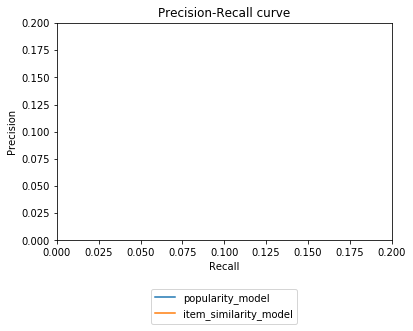

In [33]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")


### Evaluation Metric - Precision Recall curve using pickled results on a larger data subset
In order to visualise a better precision recall curve I have taken the larger dataset pickled results to demonstrate the curves for both the popularity and item based recommendation engines

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


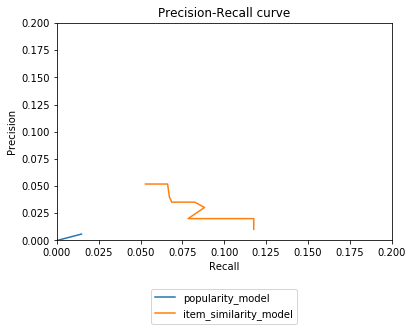

In [34]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

#Read the persisted files 
pm_avg_precision_list = joblib.load('pm_avg_precision_list_3.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_3.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_3.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_3.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

The curve shows that the personalized model provides much better performance over the popularity model. 